In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from services.machine_service import MachineService
from services.experiment_service import ExperimentService

######################################################################
# Needed functions for which I didn't find the right place. Probably to be moved to rawpy
def elastic_correction(stress, disp, k):
    """
    Apply elastic correction to displacement data.

    Parameters:
    stress (np.ndarray): The stress data array.
    disp (np.ndarray): The displacement data array.
    k (float or np.ndarray): The stiffness value (scalar or array).

    Returns:
    np.ndarray: Elastic corrected displacement data.
    """
    # Convert scalar k to an array if it is not already an array
    if np.isscalar(k):
        k = k
    else:
        k = k[:-1]

    # Increments in elastic distortion
    dload = (stress[1:] - stress[:-1]) / k
    # Increments in total displacement
    ddisp = disp[1:] - disp[:-1]
    # Subtract elastic distortion from total displacement
    ec_disp = np.hstack([0, np.cumsum(ddisp - dload)])
    return ec_disp

def detect_touch_point(force_readings, check_up2load=10):
    """
    Detects the touch point where the force readings consistently stay above the moving average.
    
    Parameters:
    - force_readings: [kN] The time series data of force readings.
    - check_up2load: [kN] touch point is searched in the segment before the first occurrence of this value
    Returns:
    - The index of the touch point.
    """
    min_list = []
    max_list = []
    average_list = []
    idx_lim = np.argmax(force_readings>check_up2load)
    force_readings = force_readings[:idx_lim] - force_readings[0]
    for N in range(1, len(force_readings)):
        min_list.append(np.min(force_readings[:N]))
        max_list.append(np.max(force_readings[:N]))
        average_list.append(np.mean(force_readings[:N]))
    
    for i in range(1, len(average_list)):
        if all(force_readings[j] > average_list[j] for j in range(i, len(average_list))):
            print(f"Touch point detected at index: {i}")
            return i + 1  # Return the index adjusted to the original data
    
    return -1  # Return -1 if no touch point is detected

########################################################################################
# Connect to database
ms = MachineService()
es = ExperimentService()

# Choose the experiment to analyze
experiment_id = 's0144sa03min22'
machine_id = 'Brava2'
experiment_info = es.get_experiment_by_id(experiment_id)
experiment_date = experiment_info['Start_Datetime']
group_name = "ADC"     # the measurements in the tdms file are stored under this denominations

# Fetch the centralized measurements (the ones coming from the VI)
vertical_load_measurements = es.get_centralized_measurements(experiment_id=experiment_id, group_name=group_name, channel_name= 'Vertical Load')
horizontal_load_measurements = es.get_centralized_measurements(experiment_id, group_name=group_name, channel_name= 'Horizontal Load')
vertical_displacement_measurements = es.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Vertical Displacement')
horizontal_displacement_measurements = es.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Horizontal Displacement')
time_measurements = es.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Time')

Vertical_Load_recorded = np.array(vertical_load_measurements['data'])
Horizontal_Load_recorded = np.array(horizontal_load_measurements['data'])
Vertical_Displacement = np.array(vertical_displacement_measurements['data'])
Horizontal_Displacement = np.array(horizontal_displacement_measurements['data'])
time_s = np.array(time_measurements['data'])
records_na = np.arange(len(time_s))     # same operation done in rawpy

# Fetch the properties for visualization scaling
# For the actually implementation, you need it to offset voltage values for loads measurement
vertical_visualization_scaling = vertical_load_measurements['properties']['Slope']
vertical_intercept = vertical_load_measurements['properties']['Intercept']
horizontal_visualization_scaling = horizontal_load_measurements['properties']['Slope']
horizontal_intercept = horizontal_load_measurements['properties']['Intercept']

vertical_offset = vertical_intercept/vertical_visualization_scaling
horizontal_offset= horizontal_intercept/horizontal_visualization_scaling

vertical_load_voltage = Vertical_Load_recorded + vertical_offset
horizontal_load_voltage = Horizontal_Load_recorded + horizontal_offset

vertical_load_kN = ms.apply_calibration(machine_id, 'vertical', vertical_load_voltage, experiment_date)
horizontal_load_kN = ms.apply_calibration(machine_id, 'horizontal', horizontal_load_voltage, experiment_date)



MongoDB is running.
MongoDB is running.
Experiment s0144sa03min22 found
Applied calibration for piston vertical in machine Brava2.
Applied calibration for piston horizontal in machine Brava2.


In [2]:

# This information can be retrieved from the lateral block sizes: gouge area is just x*y dimensions
gouge_area = 0.0025 # m^2. It can be retrieved from the dimensions of the blocks
# Query for block dimensions
blocks = es.get_blocks(experiment_id=experiment_id)
if not blocks:
    # Add blocks to the experiment if not present
    es.add_block(experiment_id=experiment_id, block_id="paglialberi_1",position="left"),
    es.add_block(experiment_id=experiment_id, block_id="central_1",position="central"),
    es.add_block(experiment_id=experiment_id, block_id="paglialberi_2",position="right")
    blocks = es.get_blocks(experiment_id=experiment_id)



# Calculate the gouge area
lateral_block_dimensions = blocks[0]["dimensions"]
gouge_area_mm2 = lateral_block_dimensions['width'] * lateral_block_dimensions['height']  # Assuming uniform block dimensions
conversion_parameter = 1e3 *1e-6* gouge_area  # from kN to MPa, so from force to stress


Experiment s0144sa03min22 found
MongoDB is running.
block paglialberi_1 found
block central_1 found
block paglialberi_2 found


In [3]:
gouge_area_mm2

2500

In [4]:

#### Vertical stress ###
#### This is the point at which the ram contacted the blocks and load shear loading began
#### So far it is chosen looking at the plot, but it must be automatize too. DONE
# beg_row_v = 2808
beg_row_v = detect_touch_point(vertical_load_kN, check_up2load=10)
##################################

# ZERO DATA
# add in force from the central block due to gravity
# v_load = v_load + 0.044 #[kN]
# remove noise before load is applied
vertical_load_kN = vertical_load_kN - vertical_load_kN[beg_row_v]
vertical_load_kN[:beg_row_v]= vertical_load_kN[:beg_row_v]*0
# calculate stress for DDS 5x5
shear_stress_MPa = vertical_load_kN/(2*conversion_parameter)      # why that "2" Lo sforzo di taglio va suddiviso sui due gouges, non cosi quello normale!!!

# Note:  
# 1. These values are calculated for a 5x5[cm] shear surface  
# 2. Stiffness is non linear at low applied loads  
# TO DO: implement a function that corrects for non-linear stiffness: this has been done by Pignalberi
# Here the vertical force is zeroed 
vertical_force = np.where(vertical_load_kN > 0, vertical_load_kN, 0)
#### vertical disp ####
load_point_disp = Vertical_Displacement - Vertical_Displacement[beg_row_v] # [mum]
load_point_disp[:beg_row_v] = load_point_disp[:beg_row_v]*0
load_point_disp_mm = load_point_disp/1000       # [mm]

# Elastic correction for the stretch of the vertical frame # 
vertical_k_constant = 166.801 #[MPa/mm]         # calibration from loading and unloading cycles on steel: linear approx
vertical_k = ms.apply_stiffness_correction(machine_id, 'vertical', vertical_load_kN, experiment_date)

# "Elastic corrected" displacement
vertical_displacement_corrected_mm = elastic_correction(shear_stress_MPa, load_point_disp_mm, vertical_k) 
vertical_displacement_corrected_mm_old = elastic_correction(shear_stress_MPa, load_point_disp_mm, vertical_k_constant)

#############  normal load ############ 
#### Normal load is applied at record
# beg_row_h = 234
beg_row_h = detect_touch_point(horizontal_load_kN, check_up2load=10)

######################################
# zero the data
horizontal_load_kN = horizontal_load_kN - horizontal_load_kN[beg_row_h]
# remove noise before load is applied 
horizontal_load_kN[:beg_row_h] = horizontal_load_kN[:beg_row_h]*0
# calculate stress for DDS 5x5
normal_stress_MPa =  horizontal_load_kN/(conversion_parameter)
#add a small number to normal stress 
#so that we aren't dividing by 0 anywhere to calculate mu 
epsilon = 1e-7
normal_stress_MPa = normal_stress_MPa + epsilon

# Note:  
# 1. These values are calculated for a 5x5[cm] shear surface  
# 2. Stiffness is non linear at low applied loads  
# TO DO: implement a function that corrects for non-linear stiffness. Pignalberi has done it
horizontal_force = np.where(vertical_load_kN > 0, vertical_load_kN, 0)

# Elastic correction for the stretch of the horizontal frame #
horizontal_k_constant = 125.363 #[MPa/mm]              # calibration from loading and unloading cycles on steel: linear approx
horizontal_k = ms.apply_stiffness_correction(machine_id, 'horizontal', horizontal_load_kN, experiment_date)

# Carolina, correzione iniziale serve nel caso carico normale variabile e se necessario valore assoluto layer thickNess (tipo, fase iniziale)
horizontal_displacement_corrected_mm = elastic_correction(normal_stress_MPa, -Horizontal_Displacement/1000,horizontal_k)   # why "-"? So that compaction is negative
horizontal_displacement_corrected_mm_old = elastic_correction(normal_stress_MPa, -Horizontal_Displacement/1000,horizontal_k_constant)

######################################################################
########## 5. Calculate layer thickNess: MUST STANDARDIZE!!! ##########################
##################################################################### 
# insert rec number at which layer thickness was measured
rec_lt = 234
# insert calculated value at that point
val_lt = 3    # [mm]
###########################################################
# zero data
layer_thickness_corrected_mm = horizontal_displacement_corrected_mm - horizontal_displacement_corrected_mm[rec_lt]
layer_thickness_corrected_mm_half = layer_thickness_corrected_mm/2
layer_thickness_corrected_mm1 = layer_thickness_corrected_mm_half + val_lt

layer_thickness_corrected_mm_old = horizontal_displacement_corrected_mm_old - horizontal_displacement_corrected_mm_old[rec_lt]
layer_thickness_corrected_mm_old_half = layer_thickness_corrected_mm_old/2
layer_thickness_corrected_mm_old1 = layer_thickness_corrected_mm_old_half + val_lt

# # default unit is [mm]
# rgt_lt_mm = rp.rgt(load_point_disp_mm,layer_thickness_corrected_mm1)     # remove geometrical thinning
# # 6. Calculate friction 
friction_na = shear_stress_MPa / normal_stress_MPa

# # 7. Calculate shear strain. Marco dice indifferente lt o quella corretta per geometrical thinning
# shear_strain_na = rp.shear_strain(ec_disp_mm,layer_thickness_corrected_mm1)


Touch point detected at index: 2703
Applied stiffness correction for piston vertical in machine Brava2.
Touch point detected at index: 234
Applied stiffness correction for piston horizontal in machine Brava2.


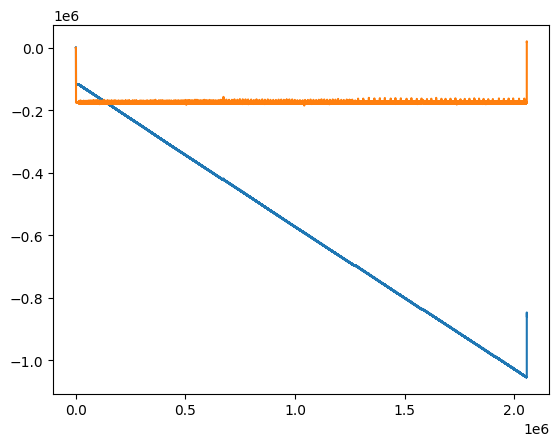

In [5]:
plt.plot(horizontal_displacement_corrected_mm)
plt.plot(horizontal_displacement_corrected_mm_old)